# Performing the same analysis from notebook 2.0 again with 5 epoch runs.

I'm doing this later, so I'm just going to do a second notebook rather than try to overwrite the previous results

## Notes during training:

- It looks like there is consistent improvement through the training runs, regardless of the number of training epochs we perform (3 vs 5). This seems to indicate that we need to improve the learning rate scheduling: faster initial annealing, slower later
- Similar output accuracies, similar continuous improvement to the 3-epoch case.
- I mistakenly added random tokens to the _end_ of the tokens rather than the beginning in one run: showed some promise.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm

import torch

In [2]:
from src.model.setup import image_model_setup
from src.model.CLS_token_probing import ModuleSpecificDecoder
model_name = "facebook/dinov2-base"
dataset_name = "temp_dataset_subsample"

model, image_datasets, _ = image_model_setup(model_name, dataset_name, 1000)
_=model.model.eval()
model_analysis, _, _ = image_model_setup(model_name, dataset_name, 1000)
model_analysis.to('mps')
_=model_analysis.model.eval()

W0213 23:54:08.064000 10576 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from pathlib import Path
from src.data.activity_dataset import OnlineLayerInputDataset


def test_probe(layer_ind, mode, split):
    layer_name = f'dinov2.encoder.layer.{layer_ind}'

    root_dir = Path(f'probes_{mode}_reinit/')
    
    probe =  ModuleSpecificDecoder.from_pretrained(root_dir / f'layer{layer_ind}_probe_{mode}',
                                                   mode=mode
                                                  )
    probe = probe.eval()
    probe = probe.to('mps')

    ds = OnlineLayerInputDataset(model, layer_name, image_datasets[split], device='mps')

    base_module = model_analysis.module_dict[layer_name]
    
    results = {'prediction':[], 'labels':[]}

    with torch.no_grad():
        for batch in tqdm(ds, total=50000/64):
            results['prediction'].append(probe.forward( batch[layer_name], base_module
                                                    ).detach().clone().cpu().argmax(1)
                                        )
            results['labels'].append(batch['label'].cpu())

    for key in results:
        results[key] = torch.concat(results[key])


    outputs = {}
    outputs['accuracy'] = (results['prediction'] == results['labels']).float().mean().item()
    outputs['layer'] = layer_ind
    outputs['mode'] = mode
    outputs['split'] = split
    
    return outputs


In [4]:
all_outs = []
for split in ['validation', 'test']:
    for layer in range(8,12):
        for mode in ['null', 'replace', 'augment']:
            all_outs.append(test_probe(layer, mode, split))
            print(all_outs)

Loading weights from local directory


782it [09:14,  1.41it/s]                                                          


[{'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'}]

Loading weights from local directory


782it [09:29,  1.37it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'}
]

Loading weights from local directory


782it [09:34,  1.36it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'}
]

Loading weights from local directory


782it [09:15,  1.41it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'}
]

Loading weights from local directory


782it [09:11,  1.42it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'}
]

Loading weights from local directory


782it [08:54,  1.46it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'}
]

Loading weights from local directory


782it [08:54,  1.46it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'}
]

Loading weights from local directory


782it [08:58,  1.45it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'}
]

Loading weights from local directory


782it [09:13,  1.41it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'}
]

Loading weights from local directory


782it [08:54,  1.46it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'}
]

Loading weights from local directory


782it [08:55,  1.46it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'}
]

Loading weights from local directory


782it [09:00,  1.45it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'}
]

Loading weights from local directory


782it [09:03,  1.44it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'}
]

Loading weights from local directory


782it [09:03,  1.44it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6161400079727173, 'layer': 8, 'mode': 'replace', 'split': 'test'}
]

Loading weights from local directory


782it [09:02,  1.44it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6161400079727173, 'layer': 8, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.6142200231552124, 'layer': 8, 'mode': 'augment', 'split': 'test'}
]

Loading weights from local directory


782it [09:03,  1.44it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6161400079727173, 'layer': 8, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.6142200231552124, 'layer': 8, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.6458799839019775, 'layer': 9, 'mode': 'null', 'split': 'test'}
]

Loading weights from local directory


782it [09:02,  1.44it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6161400079727173, 'layer': 8, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.6142200231552124, 'layer': 8, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.6458799839019775, 'layer': 9, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6801599860191345, 'layer': 9, 'mode': 'replace', 'split': 'test'}
]

Loading weights from local directory


782it [09:02,  1.44it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6161400079727173, 'layer': 8, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.6142200231552124, 'layer': 8, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.6458799839019775, 'layer': 9, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6801599860191345, 'layer': 9, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.678820013999939, 'layer': 9, 'mode': 'augment', 'split': 'test'}
]

Loading weights from local directory


782it [09:03,  1.44it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6161400079727173, 'layer': 8, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.6142200231552124, 'layer': 8, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.6458799839019775, 'layer': 9, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6801599860191345, 'layer': 9, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.678820013999939, 'layer': 9, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.7666000127792358, 'layer': 10, 'mode': 'null', 'split': 'test'}
]

Loading weights from local directory


782it [09:03,  1.44it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6161400079727173, 'layer': 8, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.6142200231552124, 'layer': 8, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.6458799839019775, 'layer': 9, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6801599860191345, 'layer': 9, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.678820013999939, 'layer': 9, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.7666000127792358, 'layer': 10, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.7501199841499329, 'layer': 10, 'mode': 'replace', 'split': 'test'}
]

Loading weights from local directory


782it [09:03,  1.44it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6161400079727173, 'layer': 8, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.6142200231552124, 'layer': 8, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.6458799839019775, 'layer': 9, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6801599860191345, 'layer': 9, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.678820013999939, 'layer': 9, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.7666000127792358, 'layer': 10, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.7501199841499329, 'layer': 10, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.7484999895095825, 'layer': 10, 'mode': 'augment', 'split': 'test'}
]

Loading weights from local directory


782it [09:04,  1.44it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6161400079727173, 'layer': 8, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.6142200231552124, 'layer': 8, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.6458799839019775, 'layer': 9, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6801599860191345, 'layer': 9, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.678820013999939, 'layer': 9, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.7666000127792358, 'layer': 10, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.7501199841499329, 'layer': 10, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.7484999895095825, 'layer': 10, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.7837399840354919, 'layer': 11, 'mode': 'null', 'split': 'test'}
]

Loading weights from local directory


782it [09:08,  1.43it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6161400079727173, 'layer': 8, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.6142200231552124, 'layer': 8, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.6458799839019775, 'layer': 9, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6801599860191345, 'layer': 9, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.678820013999939, 'layer': 9, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.7666000127792358, 'layer': 10, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.7501199841499329, 'layer': 10, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.7484999895095825, 'layer': 10, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.7837399840354919, 'layer': 11, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.7896000146865845, 'layer': 11, 'mode': 'replace', 'split': 'test'}
]

Loading weights from local directory


782it [09:43,  1.34it/s]                                                          


[
    {'accuracy': 0.5149199962615967, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6342800259590149, 'layer': 8, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6335399746894836, 'layer': 8, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.670199990272522, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6943600177764893, 'layer': 9, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.6939200162887573, 'layer': 9, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7679399847984314, 'layer': 10, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.7657399773597717, 'layer': 10, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.7997199892997742, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8094000220298767, 'layer': 11, 'mode': 'replace', 'split': 'validation'},
    {'accuracy': 0.8091400265693665, 'layer': 11, 'mode': 'augment', 'split': 'validation'},
    {'accuracy': 0.4891600012779236, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6161400079727173, 'layer': 8, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.6142200231552124, 'layer': 8, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.6458799839019775, 'layer': 9, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6801599860191345, 'layer': 9, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.678820013999939, 'layer': 9, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.7666000127792358, 'layer': 10, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.7501199841499329, 'layer': 10, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.7484999895095825, 'layer': 10, 'mode': 'augment', 'split': 'test'},
    {'accuracy': 0.7837399840354919, 'layer': 11, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.7896000146865845, 'layer': 11, 'mode': 'replace', 'split': 'test'},
    {'accuracy': 0.7898799777030945, 'layer': 11, 'mode': 'augment', 'split': 'test'}
]

In [7]:
pd.DataFrame(all_outs).to_csv('results/internal_probes', index=False)

In [2]:
all_outs = pd.read_csv('results/internal_probes')
all_outs = all_outs.fillna('null')

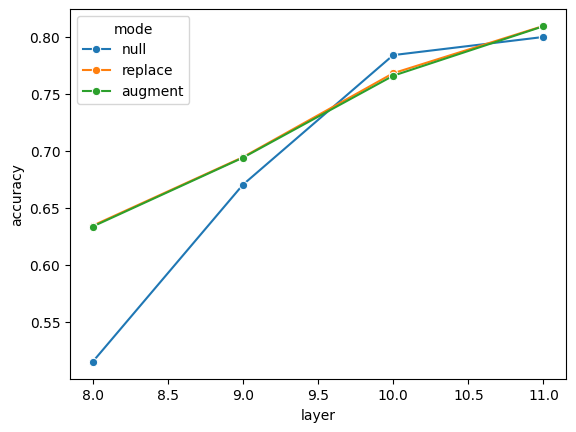

In [3]:
ax = sns.lineplot(all_outs[all_outs['split'] == 'validation'], x='layer', y='accuracy', hue='mode',
                  marker='o')

In [44]:
all_outs

,accuracy,layer,mode,split
0,0.51492,8,null,validation
1,0.63428,8,replace,validation
2,0.63354,8,augment,validation
3,0.67020,9,null,validation
4,0.69436,9,replace,validation
5,0.69392,9,augment,validation
6,0.78382,10,null,validation
7,0.76794,10,replace,validation
8,0.76574,10,augment,validation
9,0.79972,11,null,validation


/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_8517/1975434405.py:10: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.lineplot( all_outs[(all_outs['split'] == 'test') & (all_outs['mode'] != 'null')], x='layer', y='accuracy', hue='mode',


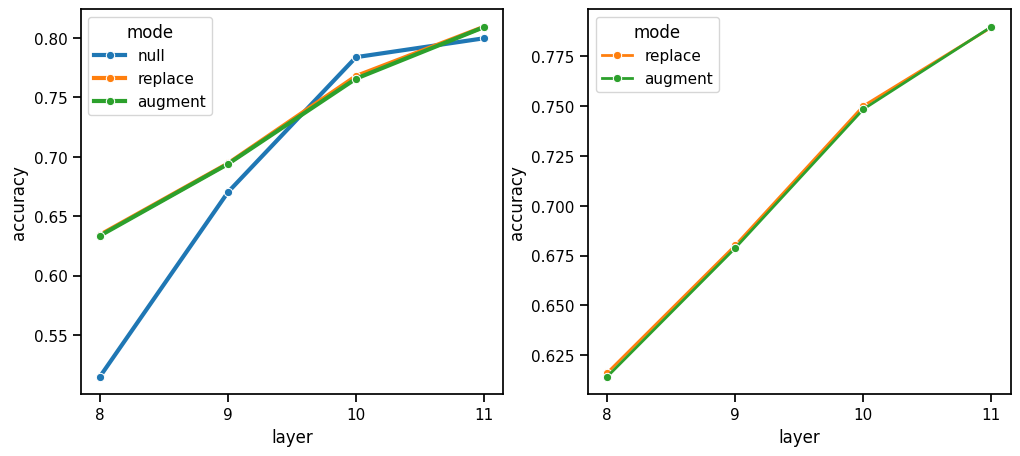

In [43]:
sns.set_context("notebook", font_scale=1.0)
figsize(12,5)
plt.subplots(1,2)

plt.subplot(1,2,1)
ax = sns.lineplot(all_outs[all_outs['split'] == 'validation'], x='layer', y='accuracy', hue='mode',
                  marker='o', linewidth=3)
ax.set_xticks(range(8,12))
plt.subplot(1,2,2)
ax = sns.lineplot( all_outs[(all_outs['split'] == 'test') & (all_outs['mode'] != 'null')], x='layer', y='accuracy', hue='mode',
              marker='o', palette=sns.color_palette()[1:],linewidth=2)
ax.set_xticks(range(8,12))
plt.savefig('accuracy_curves.png', dpi=500, bbox_inches='tight') 

<Axes: xlabel='layer', ylabel='accuracy'>

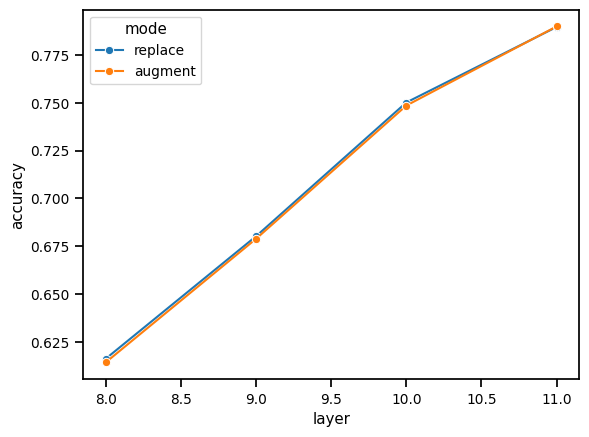

In [16]:
sns.lineplot( all_outs[(all_outs['split'] == 'test') & (all_outs['mode'] != 'null')], x='layer', y='accuracy', hue='mode',
              marker='o')

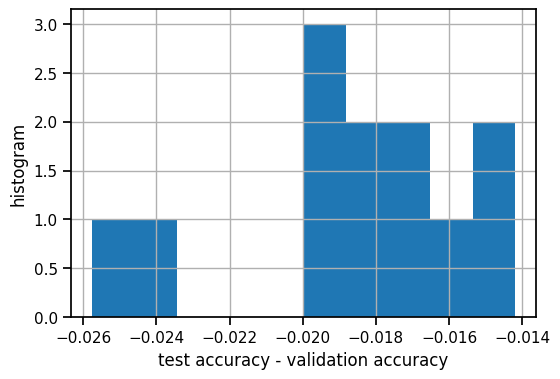

In [39]:
figsize(6,4)
by_dataset = all_outs.pivot(index=['layer', 'mode'], columns='split', values='accuracy')
diffs = by_dataset['test'] - by_dataset['validation']
diffs.hist()
plt.xlabel('test accuracy - validation accuracy', fontsize=12)
plt.ylabel('histogram', fontsize=12)
plt.savefig('accuracy_diff.png', dpi=500, bbox_inches='tight') 

### Double check

I ran a second set of null probes, reinitializing the weights from scratch at each point. I thought that the performance of the null probes (in particular at layer 11) might be the result of the initializing these probes to the fit at layer 10, and wanted to see how much impact that had on the read-out accuracy.


In [4]:
new_outs = []
mode = 'null'

for split in ['validation', 'test']:
    for layer in range(8,12):
        new_outs.append(test_probe(layer, mode, split))
        print(new_outs)

Loading weights from local directory


782it [09:22,  1.39it/s]                                                          


[{'accuracy': 0.509660005569458, 'layer': 8, 'mode': 'null', 'split': 'validation'}]

Loading weights from local directory


782it [09:02,  1.44it/s]                                                          


[
    {'accuracy': 0.509660005569458, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6654599905014038, 'layer': 9, 'mode': 'null', 'split': 'validation'}
]

Loading weights from local directory


782it [08:57,  1.45it/s]                                                          


[
    {'accuracy': 0.509660005569458, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6654599905014038, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'}
]

Loading weights from local directory


782it [08:54,  1.46it/s]                                                          


[
    {'accuracy': 0.509660005569458, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6654599905014038, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8147000074386597, 'layer': 11, 'mode': 'null', 'split': 'validation'}
]

Loading weights from local directory


782it [09:03,  1.44it/s]                                                          


[
    {'accuracy': 0.509660005569458, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6654599905014038, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8147000074386597, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.48236000537872314, 'layer': 8, 'mode': 'null', 'split': 'test'}
]

Loading weights from local directory


782it [09:02,  1.44it/s]                                                          


[
    {'accuracy': 0.509660005569458, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6654599905014038, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8147000074386597, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.48236000537872314, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6420599818229675, 'layer': 9, 'mode': 'null', 'split': 'test'}
]

Loading weights from local directory


782it [09:03,  1.44it/s]                                                          


[
    {'accuracy': 0.509660005569458, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6654599905014038, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8147000074386597, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.48236000537872314, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6420599818229675, 'layer': 9, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.7666000127792358, 'layer': 10, 'mode': 'null', 'split': 'test'}
]

Loading weights from local directory


782it [09:03,  1.44it/s]                                                          


[
    {'accuracy': 0.509660005569458, 'layer': 8, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.6654599905014038, 'layer': 9, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.7838199734687805, 'layer': 10, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.8147000074386597, 'layer': 11, 'mode': 'null', 'split': 'validation'},
    {'accuracy': 0.48236000537872314, 'layer': 8, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.6420599818229675, 'layer': 9, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.7666000127792358, 'layer': 10, 'mode': 'null', 'split': 'test'},
    {'accuracy': 0.7990000247955322, 'layer': 11, 'mode': 'null', 'split': 'test'}
]

In [7]:
new_outs = pd.DataFrame(new_outs)

In [8]:
new_outs.to_csv('results/probes_reinit')

In [14]:
all_outs = pd.read_csv('results/internal_probes')
all_outs = all_outs.fillna('null')

In [32]:
new_outs = pd.read_csv('results/probes_reinit')
new_outs = new_outs.fillna('null_reinit')

In [34]:
new_outs[new_outs['split'] == 'test']

,Unnamed: 0,accuracy,layer,mode,split
4,4,0.48236,8,null_reinit,test
5,5,0.64206,9,null_reinit,test
6,6,0.76660,10,null_reinit,test
7,7,0.79900,11,null_reinit,test


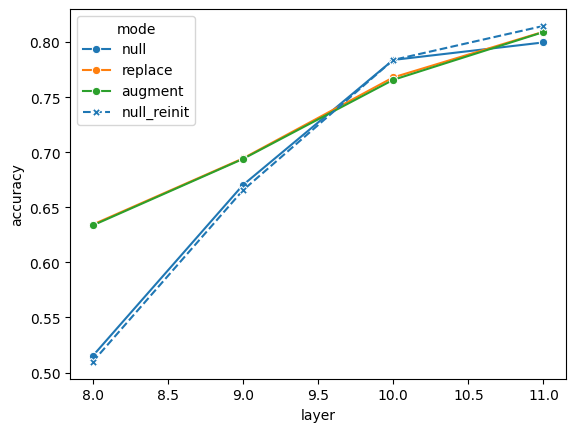

In [37]:
sns.lineplot( all_outs[(all_outs['split'] == 'validation')], x='layer', y='accuracy', hue='mode',
              marker='o')
sns.lineplot( new_outs[new_outs['split'] == 'validation'], x='layer', y='accuracy', hue='mode',
              marker='X', linestyle='--')
plt.savefig('alt_accuracy_curves.png', dpi=500, bbox_inches='tight') 

Interpretation-wise, the reinitialized probes are cleaner: they are worse at lower layers, and better at higher layers that the other probing methods. However, it's not really a fair comparison to make with the replace and augment probes, which were not trained with reinitialization.

At the same time, re-running this experiment again seems over-kill at this point. I think that the best course of action is to simply show both plots.